In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import HeatMap
from IPython.display import IFrame
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Step 1: Load Data
df = pd.read_csv("forestfires.csv")
np.random.seed(42)
df['lat'] = np.random.uniform(40.0, 42.0, len(df))
df['lon'] = np.random.uniform(-8.5, -7.5, len(df))

In [4]:
# Step 2: Feature Engineering
df['fire_risk'] = df['area'].apply(lambda x: 1 if x > 0 else 0)

df = pd.get_dummies(df, columns=['month', 'day'], drop_first=True)

df['temp_wind_interaction'] = df['temp'] * df['wind']
df['dryness_index'] = (df['FFMC'] + df['DMC'] + df['DC']) / 3

scaler = StandardScaler()
numerical_cols = ['temp', 'RH', 'wind', 'rain', 'FFMC', 'DMC', 'DC', 'ISI',
                  'temp_wind_interaction', 'dryness_index']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

X = df.drop(columns=['area', 'fire_risk', 'lat', 'lon'])
y = df['fire_risk']

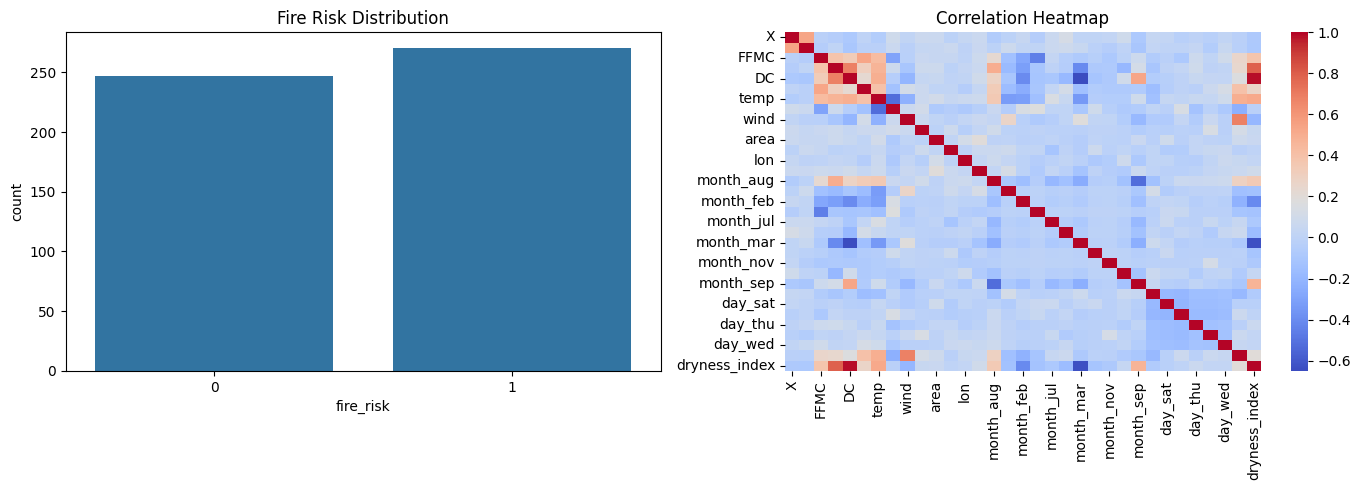

In [5]:
# Step 3: EDA Visualizations
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='fire_risk', data=df, ax=axs[0])
axs[0].set_title("Fire Risk Distribution")

sns.heatmap(df.corr(), cmap='coolwarm', ax=axs[1])
axs[1].set_title("Correlation Heatmap")

plt.tight_layout()
plt.show()

In [6]:
# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [7]:
# Step 5: Random Forest Model
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_


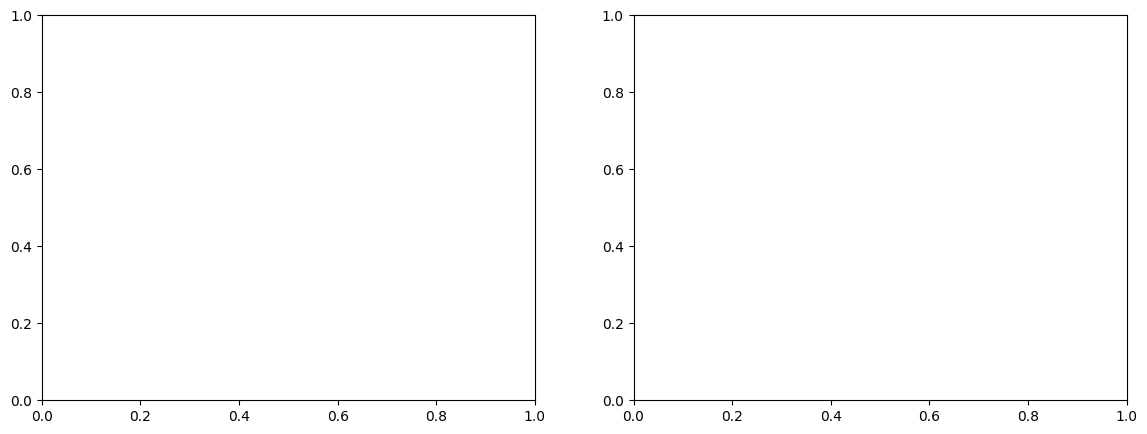

In [8]:
# Step 6: Model Evaluation
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

clf_report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_proba)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

In [9]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
axs[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
axs[1].plot([0, 1], [0, 1], linestyle='--')
axs[1].set_title("ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].legend()

plt.tight_layout()
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)

<Figure size 640x480 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.45      0.49        51
           1       0.55      0.64      0.59        53

    accuracy                           0.55       104
   macro avg       0.55      0.55      0.54       104
weighted avg       0.55      0.55      0.54       104

ROC-AUC Score: 0.6444691083980763


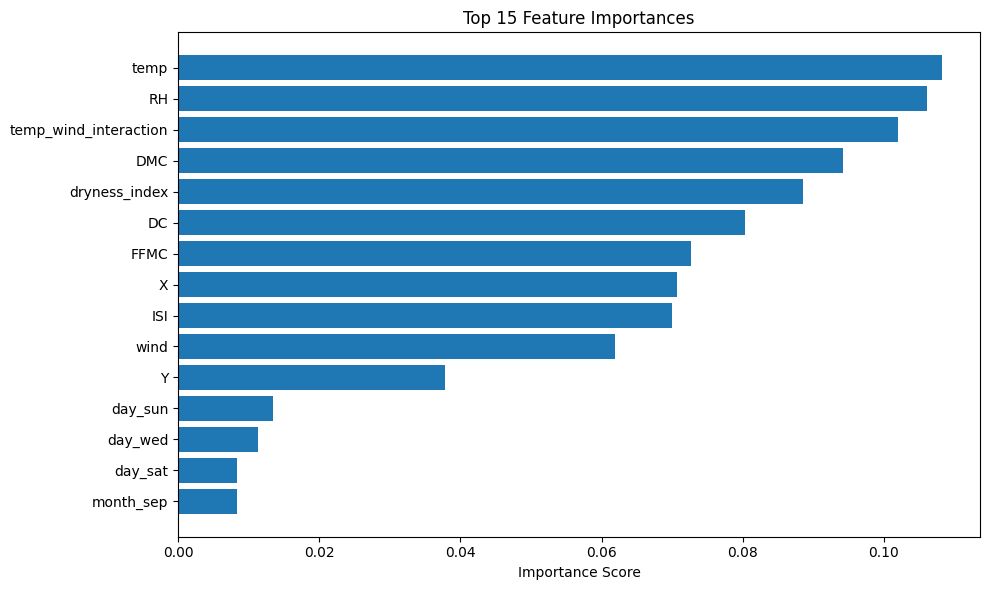

In [10]:
# Step 7: Feature Importances
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [12]:
# Step 8: Spatial Visualization
fire_map = folium.Map(location=[41.0, -8.0], zoom_start=7)

heat_data = [[row['lat'], row['lon']] for index, row in df[df['fire_risk'] == 1].iterrows()]
HeatMap(heat_data).add_to(fire_map)

# Save map to file and show in notebook
map_file = "fire_risk_heatmap.html"
fire_map.save(map_file)

try:
  import webbrowser
  webbrowser.open("fire_risk_heatmap.html")
except:
    print("Interactive map saved as 'fire_risk_heatmap.html'. Open it in a browser to view.")